# Plot effective kernel of our filters

In [155]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy

In [2]:
import gcm_filters

In [3]:
list(gcm_filters.GridType)

[<GridType.REGULAR: 1>,
 <GridType.REGULAR_WITH_LAND: 2>,
 <GridType.IRREGULAR_WITH_LAND: 3>,
 <GridType.TRIPOLAR_REGULAR_WITH_LAND: 4>,
 <GridType.TRIPOLAR_POP_WITH_LAND: 5>,
 <GridType.VECTOR_C_GRID: 6>]

In [5]:
gcm_filters.required_grid_vars(gcm_filters.GridType.IRREGULAR_WITH_LAND)

['wet_mask', 'dxw', 'dyw', 'dxs', 'dys', 'area', 'kappa_w', 'kappa_s']

## Open POP 0.1 degree data

In [8]:
ds = xr.open_dataset('/glade/work/igrooms/current_data', decode_times=False)

### Make ocean ("wet") mask

In [9]:
wet_mask = xr.where(ds['KMT']>0,1,0)

Text(0.5, 1.0, 'wet_mask')

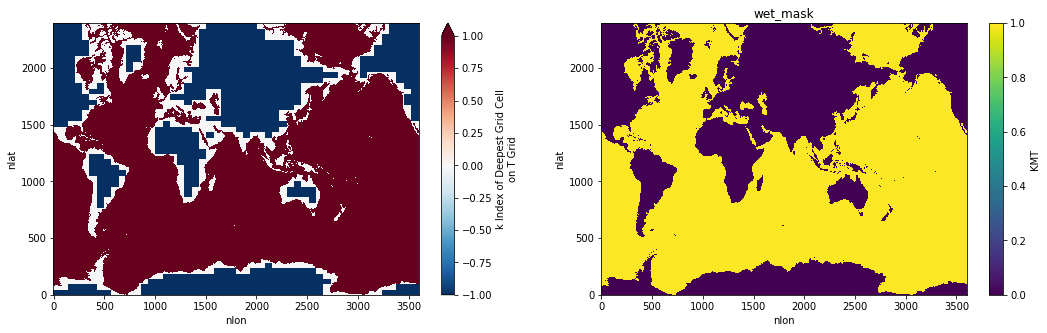

In [10]:
fig,axs = plt.subplots(1,2,figsize=(18,5))
ds.KMT.plot(ax=axs[0],vmin=ds.KMT.min())
wet_mask.plot(ax=axs[1])
axs[1].set_title('wet_mask')

### Create remaining grid info required by `IRREGULAR_WITH_LAND` Laplacian 

In [11]:
# grid spacings in m
HUS = ds.HUS.where(wet_mask)/100 
HTE = ds.HTE.where(wet_mask)/100 
HTN = ds.HTN.where(wet_mask)/100 
HUW = ds.HUW.where(wet_mask)/100 
TAREA = ds.TAREA.where(wet_mask)/10000

dxw = HUS.roll(nlon=-1, roll_coords=False)  # x-spacing centered at western T-cell edge
dyw = HTE.roll(nlon=-1, roll_coords=False)  # y-spacing centered at western T-cell edge
dxs = HTN.roll(nlat=-1, roll_coords=False)  # x-spacing centered at southern T-cell edge
dys = HUW.roll(nlat=-1, roll_coords=False)  # y-spacing centered at southern T-cell edge in m
tarea = TAREA  # cell area

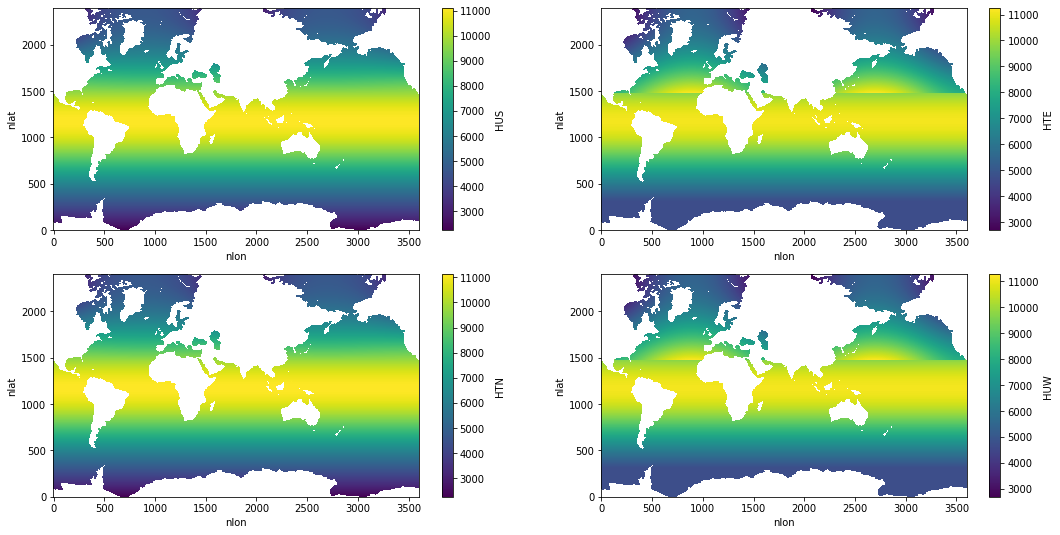

In [12]:
fig,axs = plt.subplots(2,2,figsize=(18,9))
dxw.plot(ax=axs[0,0])
dyw.plot(ax=axs[0,1])
dxs.plot(ax=axs[1,0])
dys.plot(ax=axs[1,1])

In [13]:
dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_min = dx_min.values
dx_min

array(2245.78304344)

# Define spatial filters

In [186]:
filter_scale = 40000

We will test 
* two different filter shapes: Gaussian and Taper
* two sets of kappa: one set defining isotropic filtering, one set defining anisotropic filtering

### Gaussian

In [187]:
filter_Gaussian_isotropic = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=0, 
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': tarea, 'kappa_w': xr.ones_like(wet_mask), 'kappa_s': xr.ones_like(wet_mask)}
)
filter_Gaussian_isotropic

Filter(filter_scale=40000, dx_min=array(2245.78304344), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=20, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

In [188]:
filter_Gaussian_anisotropic = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=0,  
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': tarea, 'kappa_w': xr.ones_like(wet_mask), 'kappa_s': 0.1*xr.ones_like(wet_mask)}
)
filter_Gaussian_anisotropic

Filter(filter_scale=40000, dx_min=array(2245.78304344), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=20, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

### Taper

In [189]:
filter_Taper_isotropic = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.TAPER,
    n_steps=0,  
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': tarea, 'kappa_w': xr.ones_like(wet_mask), 'kappa_s': xr.ones_like(wet_mask)}
)
filter_Taper_isotropic

Filter(filter_scale=40000, dx_min=array(2245.78304344), filter_shape=<FilterShape.TAPER: 2>, transition_width=3.141592653589793, ndim=2, n_steps=70, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

In [201]:
filter_Taper_anisotropic = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.TAPER,
    n_steps=0,  
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': tarea, 'kappa_w': xr.ones_like(wet_mask), 'kappa_s': 0.25*xr.ones_like(wet_mask)}
)
filter_Taper_anisotropic

Filter(filter_scale=40000, dx_min=array(2245.78304344), filter_shape=<FilterShape.TAPER: 2>, transition_width=3.141592653589793, ndim=2, n_steps=70, grid_type=<GridType.IRREGULAR_WITH_LAND: 3>)

## Fixed factor

Also test fixed factor.

In [191]:
filter_fixed_factor_Gaussian = gcm_filters.Filter(
    filter_scale=10,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=0, 
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask}
)
filter_fixed_factor_Gaussian

Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=11, grid_type=<GridType.REGULAR_WITH_LAND: 2>)

In [192]:
filter_fixed_factor_Taper = gcm_filters.Filter(
    filter_scale=10,
    dx_min=1,
    filter_shape=gcm_filters.FilterShape.TAPER,
    n_steps=0,  
    grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
    grid_vars={'wet_mask': wet_mask}
)
filter_fixed_factor_Taper

Filter(filter_scale=10, dx_min=1, filter_shape=<FilterShape.TAPER: 2>, transition_width=3.141592653589793, ndim=2, n_steps=39, grid_type=<GridType.REGULAR_WITH_LAND: 2>)

### Filter delta functions close to Antarctic Peninsula

In [194]:
delta1 = 0 * xr.ones_like(ds.nlat*ds.nlon) 
delta1[300,350] = 1
delta1 = delta1.where(wet_mask)

delta2 = 0 * xr.ones_like(ds.nlat*ds.nlon) 
delta2[270,405] = 1
delta2 = delta2.where(wet_mask)

delta3 = 0 * xr.ones_like(ds.nlat*ds.nlon) 
delta3[330,450] = 1
delta3 = delta3.where(wet_mask)

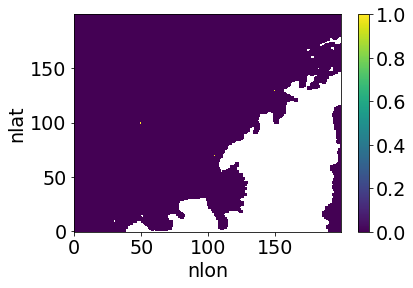

In [195]:
# Antarctic peninsula region
nlon0 = 300
nlon1 = 500
nlat0 = 200
nlat1 = 400
xslice = slice(nlon0,nlon1)
yslice = slice(nlat0,nlat1)

(delta1+delta2+delta3).isel(nlat=yslice, nlon=xslice).plot()

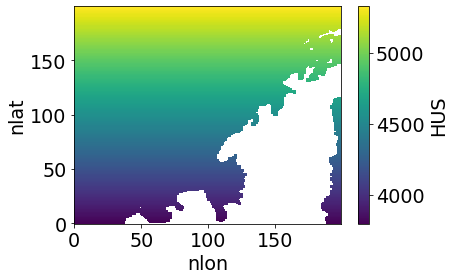

In [196]:
dxw.isel(nlat=yslice, nlon=xslice).plot()

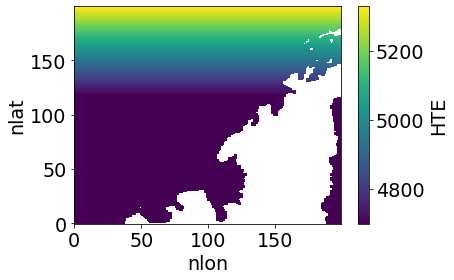

In [197]:
dyw.isel(nlat=yslice, nlon=xslice).plot()

In [202]:
delta1_filtered_Gaussian_isotropic = filter_Gaussian_isotropic.apply(delta1, dims=['nlat', 'nlon'])
delta2_filtered_Gaussian_isotropic = filter_Gaussian_isotropic.apply(delta2, dims=['nlat', 'nlon'])
delta3_filtered_Gaussian_isotropic = filter_Gaussian_isotropic.apply(delta3, dims=['nlat', 'nlon'])

delta1_filtered_Gaussian_anisotropic = filter_Gaussian_anisotropic.apply(delta1, dims=['nlat', 'nlon'])
delta2_filtered_Gaussian_anisotropic = filter_Gaussian_anisotropic.apply(delta2, dims=['nlat', 'nlon'])
delta3_filtered_Gaussian_anisotropic = filter_Gaussian_anisotropic.apply(delta3, dims=['nlat', 'nlon'])

delta1_filtered_Taper_isotropic = filter_Taper_isotropic.apply(delta1, dims=['nlat', 'nlon'])
delta2_filtered_Taper_isotropic = filter_Taper_isotropic.apply(delta2, dims=['nlat', 'nlon'])
delta3_filtered_Taper_isotropic = filter_Taper_isotropic.apply(delta3, dims=['nlat', 'nlon'])

delta1_filtered_Taper_anisotropic = filter_Taper_anisotropic.apply(delta1, dims=['nlat', 'nlon'])
delta2_filtered_Taper_anisotropic = filter_Taper_anisotropic.apply(delta2, dims=['nlat', 'nlon'])
delta3_filtered_Taper_anisotropic = filter_Taper_anisotropic.apply(delta3, dims=['nlat', 'nlon'])

delta1_filtered_fixed_factor_Gaussian = filter_fixed_factor_Gaussian.apply(delta1*tarea, dims=['nlat', 'nlon'])
delta1_filtered_fixed_factor_Gaussian = delta1_filtered_fixed_factor_Gaussian/tarea
delta2_filtered_fixed_factor_Gaussian = filter_fixed_factor_Gaussian.apply(delta2*tarea, dims=['nlat', 'nlon'])
delta2_filtered_fixed_factor_Gaussian = delta2_filtered_fixed_factor_Gaussian/tarea
delta3_filtered_fixed_factor_Gaussian = filter_fixed_factor_Gaussian.apply(delta3*tarea, dims=['nlat', 'nlon'])
delta3_filtered_fixed_factor_Gaussian = delta3_filtered_fixed_factor_Gaussian/tarea

delta1_filtered_fixed_factor_Taper = filter_fixed_factor_Taper.apply(delta1*tarea, dims=['nlat', 'nlon'])
delta1_filtered_fixed_factor_Taper = delta1_filtered_fixed_factor_Taper/tarea
delta2_filtered_fixed_factor_Taper = filter_fixed_factor_Taper.apply(delta2*tarea, dims=['nlat', 'nlon'])
delta2_filtered_fixed_factor_Taper = delta2_filtered_fixed_factor_Taper/tarea
delta3_filtered_fixed_factor_Taper = filter_fixed_factor_Taper.apply(delta3*tarea, dims=['nlat', 'nlon'])
delta3_filtered_fixed_factor_Taper = delta3_filtered_fixed_factor_Taper/tarea

## Plot effective filter kernels

/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:305: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:341: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


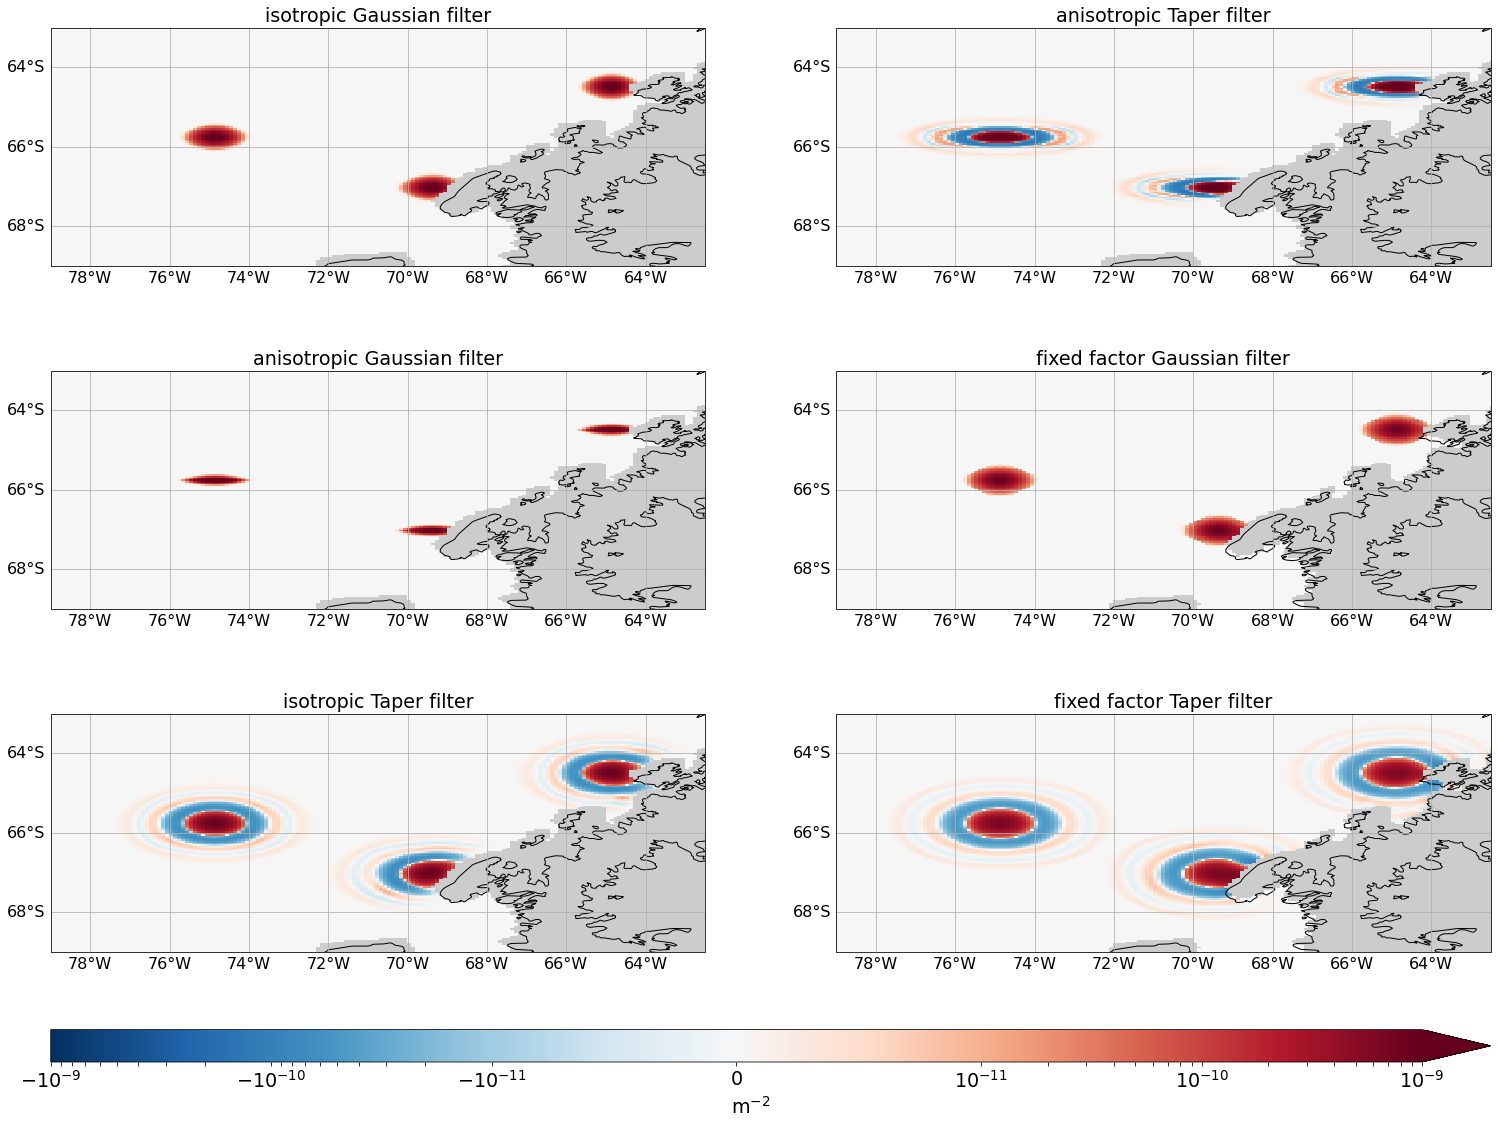

In [203]:
import matplotlib.pylab as pylab
params = {'font.size': 16}
pylab.rcParams.update(params)


fig,axs = plt.subplots(3,2,figsize=(25,15),subplot_kw={'projection':ccrs.PlateCarree()})
        
((delta1_filtered_Gaussian_isotropic+delta2_filtered_Gaussian_isotropic+delta3_filtered_Gaussian_isotropic)/tarea).isel(nlon=xslice,nlat=yslice).plot(
    ax=axs[0,0],x='ULONG',y='ULAT',
    vmin=-1e-9,vmax=1e-9,cmap='RdBu_r',
    norm=mpl.colors.SymLogNorm(linthresh=1e-11, base=10),
    add_colorbar=False,
    transform=ccrs.PlateCarree()
)

((delta1_filtered_Gaussian_anisotropic+delta2_filtered_Gaussian_anisotropic+delta3_filtered_Gaussian_anisotropic)/tarea).isel(nlon=xslice,nlat=yslice).plot(
    ax=axs[1,0],x='ULONG',y='ULAT',
    vmin=-1e-9,vmax=1e-9,cmap='RdBu_r',
    norm=mpl.colors.SymLogNorm(linthresh=1e-11, base=10),
    add_colorbar=False,
    transform=ccrs.PlateCarree())
                                                                               
((delta1_filtered_Taper_isotropic+delta2_filtered_Taper_isotropic+delta3_filtered_Taper_isotropic)/tarea).isel(nlon=xslice,nlat=yslice).plot(
    ax=axs[2,0],x='ULONG',y='ULAT',                                                                                
    vmin=-1e-9,vmax=1e-9,cmap='RdBu_r',
    norm=mpl.colors.SymLogNorm(linthresh=1e-11, base=10),                                                                              
    add_colorbar=False,                                                                                
    transform=ccrs.PlateCarree()
)

((delta1_filtered_Taper_anisotropic+delta2_filtered_Taper_anisotropic+delta3_filtered_Taper_anisotropic)/tarea).isel(nlon=xslice,nlat=yslice).plot(
    ax=axs[0,1],x='ULONG',y='ULAT',
    vmin=-1e-9,vmax=1e-9,cmap='RdBu_r',
    norm=mpl.colors.SymLogNorm(linthresh=1e-11, base=10),                                                                              
    add_colorbar=False,                                                                                
    transform=ccrs.PlateCarree()
)                               

((delta1_filtered_fixed_factor_Gaussian+delta2_filtered_fixed_factor_Gaussian+delta3_filtered_fixed_factor_Gaussian)/tarea).isel(nlon=xslice,nlat=yslice).plot(
    ax=axs[1,1],x='ULONG',y='ULAT',
    vmin=-1e-9,vmax=1e-9,cmap='RdBu_r',
    norm=mpl.colors.SymLogNorm(linthresh=1e-11, base=10),
    add_colorbar=False,                                                                                
    transform=ccrs.PlateCarree()
)
                                                                

p=((delta1_filtered_fixed_factor_Taper+delta2_filtered_fixed_factor_Taper+delta3_filtered_fixed_factor_Taper)/tarea).isel(nlon=xslice,nlat=yslice).plot(
    ax=axs[2,1],x='ULONG',y='ULAT',
    vmin=-1e-9,vmax=1e-9,cmap='RdBu_r',
    norm=mpl.colors.SymLogNorm(linthresh=1e-11, base=10),                                                                               
    add_colorbar=False,                                                                                
    transform=ccrs.PlateCarree()
)
                                                                        


for ax in axs.flatten():
    ax.coastlines()
    ax.set_extent([-79, -62.5, -69, -63], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    gl.ylocator = mticker.FixedLocator([-68,-66,-64])
    gl.xlocator = mticker.FixedLocator([-78,-76,-74,-72,-70,-68,-66,-64])
    
axs[0,0].set(title='isotropic Gaussian filter')
axs[1,0].set(title='anisotropic Gaussian filter')
axs[2,0].set(title='isotropic Taper filter')
axs[0,1].set(title='anisotropic Taper filter')
axs[1,1].set(title='fixed factor Gaussian filter')
axs[2,1].set(title='fixed factor Taper filter')
# colorbar
fig.subplots_adjust(left=0.1, bottom=-0.02)
cax = fig.add_axes([0.1, -0.1, 0.8, 0.03])
cbar = fig.colorbar(p, cax=cax, orientation='horizontal',extend='max')
cbar.set_label(label=r'm$^{-2}$', horizontalalignment='right')

plt.savefig('figures/effective_kernel_Antarctic_peninsula_scale_40km_fac_10_log_divided_by_area_latlon.png',dpi=400,bbox_inches='tight',pad_inches=0)

### Same plot but with different projection

In [204]:
from matplotlib import cm
cmap = cm.get_cmap('RdBu_r')
cmap.set_bad(color='0.8') 

params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 20}
pylab.rcParams.update(params)

/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:305: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/noraloose/my_npl_clone/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:341: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


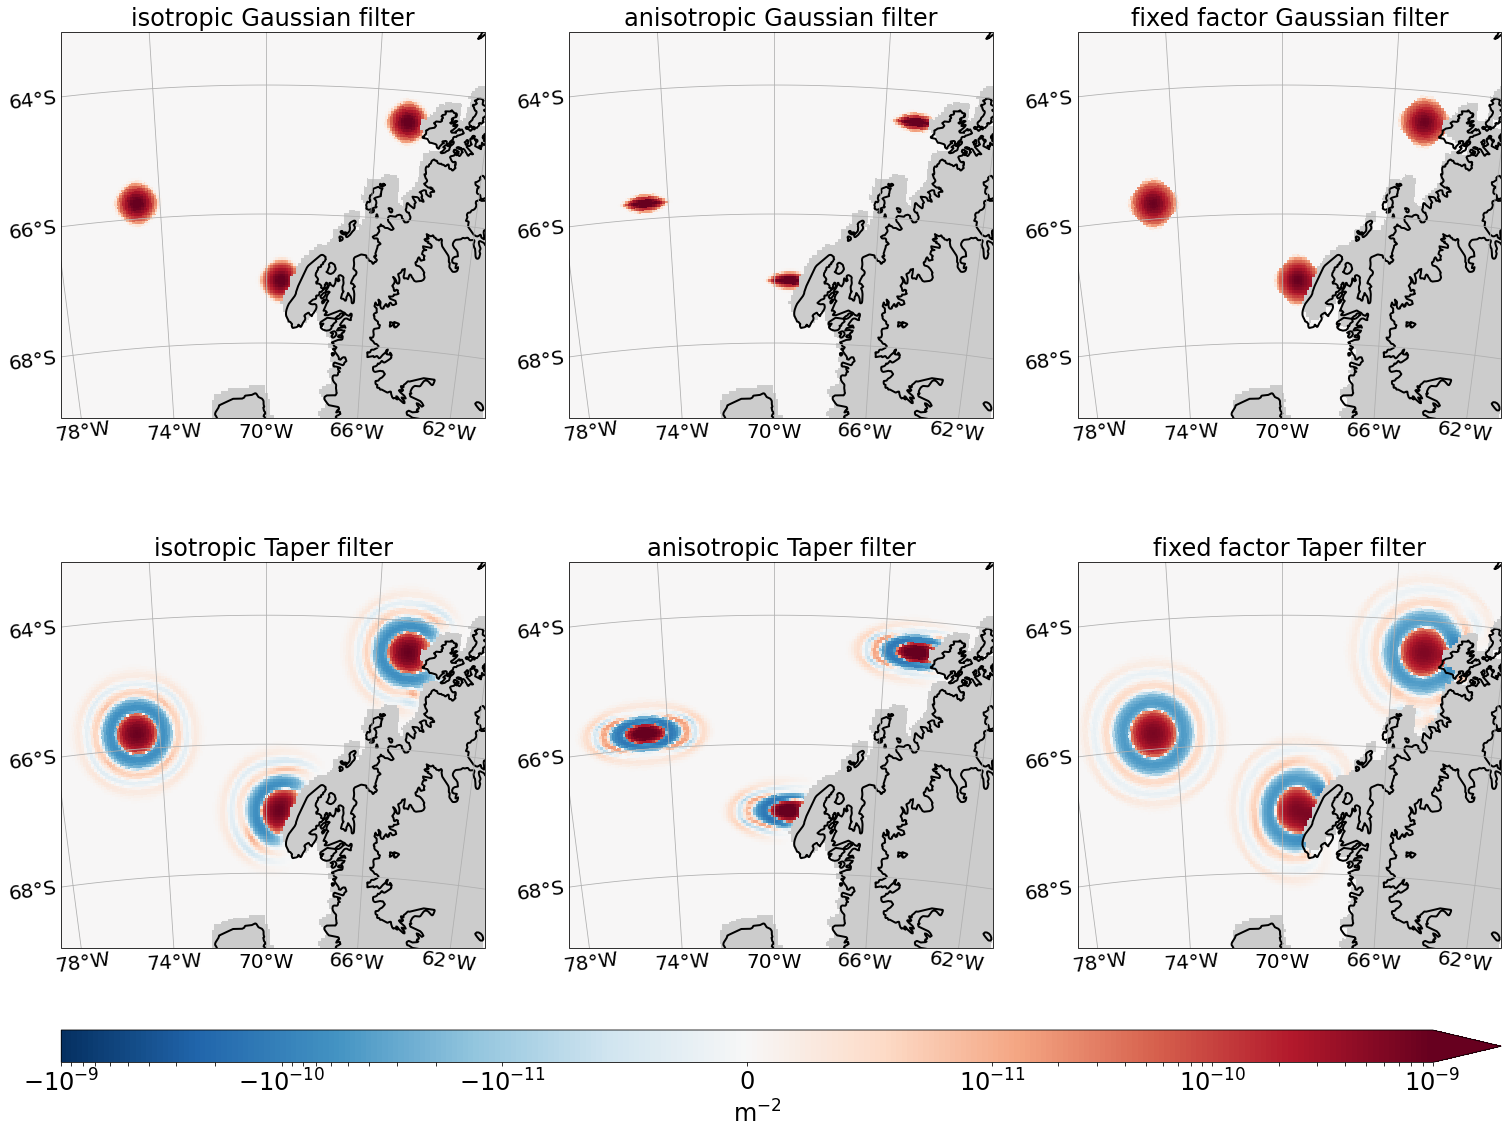

In [206]:
central_lon = -70
central_lat = -66

fig,axs = plt.subplots(2,3,figsize=(25,15),subplot_kw={'projection':ccrs.Orthographic(central_lon, central_lat)})
        
((delta1_filtered_Gaussian_isotropic+delta2_filtered_Gaussian_isotropic+delta3_filtered_Gaussian_isotropic)/tarea).isel(nlon=xslice,nlat=yslice).plot(
    ax=axs[0,0],x='ULONG',y='ULAT',
    vmin=-1e-9,vmax=1e-9,cmap='RdBu_r',
    norm=mpl.colors.SymLogNorm(linthresh=1e-11, base=10),
    add_colorbar=False,
    transform=ccrs.PlateCarree()
)

((delta1_filtered_Gaussian_anisotropic+delta2_filtered_Gaussian_anisotropic+delta3_filtered_Gaussian_anisotropic)/tarea).isel(nlon=xslice,nlat=yslice).plot(
    ax=axs[0,1],x='ULONG',y='ULAT',
    vmin=-1e-9,vmax=1e-9,cmap='RdBu_r',
    norm=mpl.colors.SymLogNorm(linthresh=1e-11, base=10),
    add_colorbar=False,
    transform=ccrs.PlateCarree()
)

((delta1_filtered_Taper_isotropic+delta2_filtered_Taper_isotropic+delta3_filtered_Taper_isotropic)/tarea).isel(nlon=xslice,nlat=yslice).plot(
    ax=axs[1,0],x='ULONG',y='ULAT',                                                                                
    vmin=-1e-9,vmax=1e-9,cmap='RdBu_r',
    norm=mpl.colors.SymLogNorm(linthresh=1e-11, base=10),                                                                              
    add_colorbar=False,                                                                                
    transform=ccrs.PlateCarree()
)

((delta1_filtered_Taper_anisotropic+delta2_filtered_Taper_anisotropic+delta3_filtered_Taper_anisotropic)/tarea).isel(nlon=xslice,nlat=yslice).plot(
    ax=axs[1,1],x='ULONG',y='ULAT',
    vmin=-1e-9,vmax=1e-9,cmap='RdBu_r',
    norm=mpl.colors.SymLogNorm(linthresh=1e-11, base=10),                                                                              
    add_colorbar=False,                                                                                
    transform=ccrs.PlateCarree()
)                               

((delta1_filtered_fixed_factor_Gaussian+delta2_filtered_fixed_factor_Gaussian+delta3_filtered_fixed_factor_Gaussian)/tarea).isel(nlon=xslice,nlat=yslice).plot(
    ax=axs[0,2],x='ULONG',y='ULAT',
    vmin=-1e-9,vmax=1e-9,cmap='RdBu_r',
    norm=mpl.colors.SymLogNorm(linthresh=1e-11, base=10),
    add_colorbar=False,                                                                                
    transform=ccrs.PlateCarree()
)
                                                                
p=((delta1_filtered_fixed_factor_Taper+delta2_filtered_fixed_factor_Taper+delta3_filtered_fixed_factor_Taper)/tarea).isel(nlon=xslice,nlat=yslice).plot(
    ax=axs[1,2],x='ULONG',y='ULAT',
    vmin=-1e-9,vmax=1e-9,cmap='RdBu_r',
    norm=mpl.colors.SymLogNorm(linthresh=1e-11, base=10),                                                                               
    add_colorbar=False,                                                                                
    transform=ccrs.PlateCarree()
)
                                                                        
axs[0,0].set(title='isotropic Gaussian filter')
axs[0,1].set(title='anisotropic Gaussian filter')
axs[1,0].set(title='isotropic Taper filter')
axs[1,1].set(title='anisotropic Taper filter')
axs[0,2].set(title='fixed factor Gaussian filter')
axs[1,2].set(title='fixed factor Taper filter')

for ax in axs.flatten():
    ax.coastlines(color='k',linewidth=2)
    ax.set_extent([-77, -62.5, -69, -63], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    gl.ylocator = mticker.FixedLocator([-68,-66,-64])
    gl.xlocator = mticker.FixedLocator([-78,-74,-70,-66,-62])
    
# colorbar
fig.subplots_adjust(left=0.1, bottom=-0.02)
cax = fig.add_axes([0.1, -0.1, 0.8, 0.03])
cbar = fig.colorbar(p, cax=cax, orientation='horizontal',extend='max')
cbar.set_label(label=r'm$^{-2}$', horizontalalignment='right')
plt.show()

fig.savefig('figures/effective_kernel_Antarctic_peninsula_scale_40km_fac_10_log_divided_by_area.pdf', dpi=400, bbox_inches='tight', pad_inches=0)